# 1. Setup and Get Data

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import os

### 2.2 Limit GPU Memory Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### 2.3 Load Image into TF Data Pipeline

#### Define Primary Dataset Source
Specify the dataset source ('webcam', 'seccam', or 'seccam2') that will be used throughout the entire image preprocessing and augmentation pipeline

In [52]:
dataset = 'seccam' # or seccam, seccam2
subsets = ['train','test','val']

Check if the dataset is available and load images for processing

In [53]:
images = tf.data.Dataset.list_files(f'data/datasets/{dataset}/train/images/*.jpg')
images.as_numpy_iterator().next()

b'data\\datasets\\seccam\\train\\images\\46b563de-83ac-11ee-8c6a-9cfeff47d2fa.jpg'

In [54]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [55]:
images = images.map(load_image)
images.as_numpy_iterator().next()
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

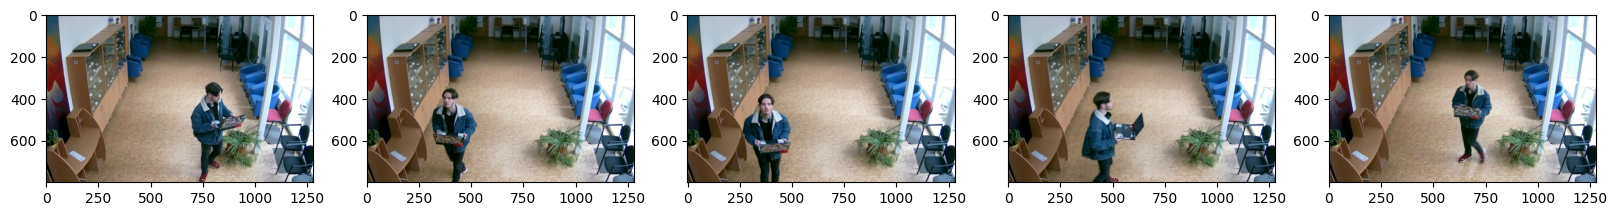

In [63]:
image_generator = images.batch(5).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
30*.7 # 21 to train

21.0

In [ ]:
30*.15 # 5 and 4 to test and val

4.5

### 3.2 Move the Matching Labels

In [ ]:
for subset in subsets:    
    for file in os.listdir(os.path.join('data', 'datasets', dataset, subset, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'datasets', dataset, 'labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data', 'datasets', dataset, subset, 'labels', filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [64]:
import albumentations as alb

In [65]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels'], 
                                                  min_area=0.001,  # Minimum area as a fraction of the image
                                                  min_visibility=0.1))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [66]:
import cv2
image_dir = os.path.join('data/datasets', dataset, 'train', 'images')
label_dir = os.path.join('data/datasets', dataset, 'train', 'labels')

# Get first image file
image_file = os.listdir(image_dir)[0]
# Get corresponding label file
label_file = image_file.split('.')[0] + '.json'

img = cv2.imread(os.path.join(image_dir, image_file))
with open(os.path.join(label_dir, label_file), 'r') as f:
    label = json.load(f)

label['shapes'][0]['points']

[[772.7433628318583, 419.46902654867256],
 [836.4601769911504, 368.14159292035396]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [70]:
coords = [0,0,0,0]
# First get x and y coordinates from both points
x1 = label['shapes'][0]['points'][0][0]
y1 = label['shapes'][0]['points'][0][1]
x2 = label['shapes'][0]['points'][1][0]
y2 = label['shapes'][0]['points'][1][1]

# Now set coordinates ensuring min and max are correct
coords[0] = min(x1, x2)  # x_min
coords[1] = min(y1, y2)  # y_min
coords[2] = max(x1, x2)  # x_max
coords[3] = max(y1, y2)  # y_max
coords

[772.7433628318583, 368.14159292035396, 836.4601769911504, 419.46902654867256]

In [71]:
coords = list(np.divide(coords, [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]))
coords

[np.float64(0.6037057522123893),
 np.float64(0.46017699115044247),
 np.float64(0.6534845132743363),
 np.float64(0.5243362831858407)]

### 4.4 Apply Augmentations and View Results

In [72]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [73]:
if len(augmented['bboxes']) != 0:
    augmented['bboxes'][0][2:]


In [74]:
augmented['bboxes']

[[0.19897735595703125,
  0.7811799494425455,
  0.34057027180989585,
  0.8952408811781142]]

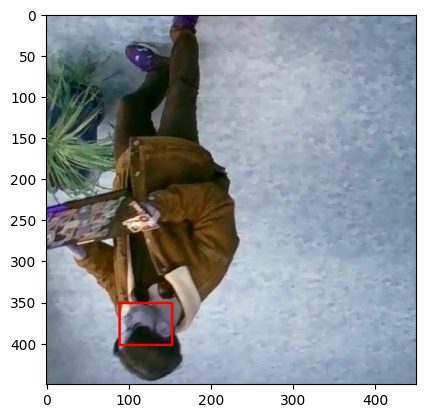

In [76]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

In [77]:
for subset in subsets: 
    for image in os.listdir(os.path.join('data/datasets', dataset, subset, 'images')):
        img = cv2.imread(os.path.join('data/datasets', dataset, subset, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data/datasets', dataset, subset, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            # Ensure coords are in correct order (x_min, y_min, x_max, y_max)
            x_min = min(label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][1][0])
            x_max = max(label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][1][0])
            y_min = min(label['shapes'][0]['points'][0][1], label['shapes'][0]['points'][1][1])
            y_max = max(label['shapes'][0]['points'][0][1], label['shapes'][0]['points'][1][1])
            
            coords = [x_min, y_min, x_max, y_max]
            coords = list(np.divide(coords, [img.shape[1], img.shape[0], img.shape[1], img.shape[0]]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                
                # Create the folder if it doesn't exist
                folder_path = os.path.join('data', 'datasets', 'augmented', dataset, subset, 'images')
                os.makedirs(folder_path, exist_ok=True)
                cv2.imwrite(os.path.join(folder_path, f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                folder_path = os.path.join('data', 'datasets', 'augmented', dataset, subset, 'labels')
                os.makedirs(folder_path, exist_ok=True)
                with open(os.path.join(folder_path, f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)